# Notebook Setup

## New Metrics Switch

In [1]:
# Boolean flag to signal whether it's necessary to load all of hte results
# and calculate new performance statistics.
# This takes several hours.
CALCULATE_NEW_METRICS = False

# If we calculate new performance statistics, they are saved in this file.
# If we do not calculate new performance statistics, old ones are loaded
# from this file.
pub_stats_filename = 'results/pub_statistics.pkl'


# We also need the time split stats for plotting.
time_split_stats_filename = 'results/time_split_statistics.pkl'

## Imports

In [2]:
import glob
import numpy as np
from pathlib import Path
import pickle as pkl

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

# The neuralhydroloy repository must exist in the current working directory.
from neuralhydrology.evaluation import metrics

## Metrics List

In [3]:
# Returns a list of all available performance metrics in NeuralHydrology
metrics_list = metrics.get_available_metrics()
print('The available metrics are:')
metrics_list

The available metrics are:


['NSE',
 'MSE',
 'RMSE',
 'KGE',
 'Alpha-NSE',
 'Pearson-r',
 'Beta-KGE',
 'Beta-NSE',
 'FHV',
 'FMS',
 'FLV',
 'Peak-Timing']

In [4]:
# Remove any metrics that you don't care about. 
# Feel free to change this.
metrics_list.remove('MSE')
metrics_list.remove('RMSE')
metrics_list.remove('FHV')
metrics_list.remove('FMS')
metrics_list.remove('FLV')
metrics_list.remove('Beta-KGE')

print('The metrics that we are going to calculate are:')
metrics_list

The metrics that we are going to calculate are:


['NSE', 'KGE', 'Alpha-NSE', 'Pearson-r', 'Beta-NSE', 'Peak-Timing']

## Basins

In [5]:
basin_file = '531_basin_list.txt'
with Path(basin_file).open('r') as fp:
    basins = sorted(basin.strip() for basin in fp if basin.strip())
print(f"There are {len(basins)} basins.")

There are 531 basins.


## Paths

In [6]:
# Paths to results from different models. 
# Note that these must match what is in the config files.
autoregression_dir = 'runs/pub/autoregression'
assimilation_dir = 'runs/pub/assimilation'
simulation_dir = 'runs/pub/simulation'

In [7]:
# Get paths to all simulation results.
simulation_run_dirs = glob.glob(simulation_dir + '/pub_simulation_*')
for i, run_dir in enumerate(simulation_run_dirs):
    simulation_run_dirs[i] = run_dir.split('/')[-1]
print(f"There are {len(simulation_run_dirs)} simulation runs.")

There are 10 simulation runs.


In [8]:
# Get paths to all assimilation results.
assimilation_run_dirs = glob.glob(assimilation_dir + '/**')
for i, run_dir in enumerate(assimilation_run_dirs):
    assimilation_run_dirs[i] = run_dir.split('/')[-1]
print(f"There are {len(assimilation_run_dirs)} assimilation runs.")

There are 10 assimilation runs.


In [9]:
# Get paths to all autoregression results.
autoregression_run_dirs = glob.glob(autoregression_dir + '/**')
for i, run_dir in enumerate(autoregression_run_dirs):
    autoregression_run_dirs[i] = run_dir.split('/')[-1]
print(f"There are {len(autoregression_run_dirs)} autoregression runs.")

There are 10 autoregression runs.


# Experiment Definition

## Infer Experiment Parameters

In [10]:
ensembles = set()
for run in autoregression_run_dirs:
    ensembles.add(int(run.split('seed_')[-1].split('_')[0]))
ensembles = sorted(list(ensembles))

## Initialize Storage

In [11]:
autoregression_statistics = {}
assimilation_statistics = {}
simulation_statistics = {}

for metric in metrics_list:
    autoregression_statistics[metric] = pd.DataFrame(index=basins, columns=ensembles, dtype=np.float64)
    assimilation_statistics[metric] = pd.DataFrame(index=basins, columns=ensembles, dtype=np.float64)
    simulation_statistics[metric] = pd.DataFrame(index=basins, columns=ensembles, dtype=np.float64)

## Load Obs Data

In [12]:
# Load in the saved metrics. 
# Even if we just calcuated them, might as well make sure the file works.
# You need to change this path manually because of the timestamp. It must
# point to a time_split directory and not to a pub directory, in order to 
# have all of the basins.
with open('runs/time_split/simulation/simulation_seed_0_1304_224615/test/model_epoch030/test_results.p', 'rb') as f:
    data_xr = pkl.load(f)

# Calculate Metrics

## Simulation

In [13]:
if CALCULATE_NEW_METRICS:
    for run in simulation_run_dirs:
        ensemble = int(run.split('seed_')[-1].split('_')[0])

        with open(simulation_dir + '/' + run + '/test/model_epoch030/test_results.p', 'rb') as f:
            run_data = pkl.load(f)

        for basin in tqdm(run_data):

            sim = run_data[basin]['1D']['xr'].stack(datetime=['date', 'time_step'])['QObs(mm/d)_sim']
            sim['datetime'] = sim.coords['date']# + sim.coords['time_step']
            obs = data_xr[basin]['1D']['xr']['QObs(mm/d)_obs'].stack(datetime=['date', 'time_step'])
            obs['datetime'] = obs.coords['date']# + obs.coords['time_step']
            basin_metrics = metrics.calculate_metrics(obs=obs, sim=sim, metrics=metrics_list)

            for metric in metrics_list:
                simulation_statistics[metric].loc[basin, ensemble] = basin_metrics[metric]

In [14]:
simulation_statistics['NSE'].median()

0   NaN
dtype: float64

## Assimilation

In [15]:
if CALCULATE_NEW_METRICS:
    for run in tqdm(assimilation_run_dirs):
        hf = float(run.split('holdout_')[-1].split('_')[0])   
        lead_time = int(run.split('lead_')[-1].split('_')[0])
        ensemble = int(run.split('seed_')[-1].split('_')[0])

        with open(assimilation_dir + '/' + run + '/test/model_epoch030/test_results_data_assimilation.p', 'rb') as f:
            run_data = pkl.load(f)

        for basin in tqdm(run_data):
            sim = run_data[basin]['1D']['xr'].stack(datetime=['date', 'time_step'])['QObs(mm/d)_sim']
            sim['datetime'] = sim.coords['date']# + sim.coords['time_step']
            obs = data_xr[basin]['1D']['xr']['QObs(mm/d)_obs'].stack(datetime=['date', 'time_step'])
            obs['datetime'] = obs.coords['date']# + obs.coords['time_step']
            basin_metrics = metrics.calculate_metrics(obs=obs, sim=sim, metrics=metrics_list)

            for metric in metrics_list:
                assimilation_statistics[metric].loc[basin, ensemble] = basin_metrics[metric]

In [16]:
assimilation_statistics['NSE'].median()

0   NaN
dtype: float64

## Autoregression

In [17]:
if CALCULATE_NEW_METRICS:
    for run in tqdm(autoregression_run_dirs):
        ensemble = int(run.split('seed_')[-1].split('_')[0])

        with open(autoregression_dir + '/' + run + '/test/model_epoch030/test_results.p', 'rb') as f:
            run_data = pkl.load(f)

        for basin in tqdm(run_data):
            sim = run_data[basin]['1D']['xr'].stack(datetime=['date', 'time_step'])['QObs(mm/d)_sim']
            sim['datetime'] = sim.coords['date']# + sim.coords['time_step']
            obs = data_xr[basin]['1D']['xr']['QObs(mm/d)_obs'].stack(datetime=['date', 'time_step'])
            obs['datetime'] = obs.coords['date']# + obs.coords['time_step']
            basin_metrics = metrics.calculate_metrics(obs=obs, sim=sim, metrics=metrics_list)

            for metric in metrics_list:
                autoregression_statistics[metric].loc[basin, ensemble] = basin_metrics[metric]

In [18]:
autoregression_statistics['NSE'].median().dropna()

Series([], dtype: float64)

## Save & Load Precaculated Metrics

In [19]:
# If we calculated new metrics, save these over any old ones that might exist.
if CALCULATE_NEW_METRICS:
    with open(pub_stats_filename, 'wb') as f:
        pkl.dump([
            simulation_statistics,
            autoregression_statistics,
            assimilation_statistics
        ], f)

In [20]:
# Load in the saved metrics. 
# Even if we just calcuated them, might as well make sure the file works.
with open(pub_stats_filename, 'rb') as f:
    pub_sim, pub_ar, pub_da = pkl.load(f)

In [21]:
# Load in the saved metrics. 
# Even if we just calcuated them, might as well make sure the file works.
with open(time_split_stats_filename, 'rb') as f:
    time_sim, time_ar, time_da = pkl.load(f)

# Figures

## Figure 1

Median NSE scores of PUB and time-split models with a lag of 1 day and no data withheld during inference.

In [23]:
# import matplotlib
# matplotlib.use('TkAgg')

In [24]:
# Function to choose plotting colors.
def _model_to_color(model: str) -> str:
    colors = {}
    colors['PUB'] = 'darkviolet'
    colors['Time-Split'] = 'teal'
    if 'PUB' in model:
        return mcolors.CSS4_COLORS[colors['PUB']]
    elif 'Time-Split' in model:
        return mcolors.CSS4_COLORS[colors['Time-Split']]
    else:
        raise ValueError(f'Model string {model} not recognized.')

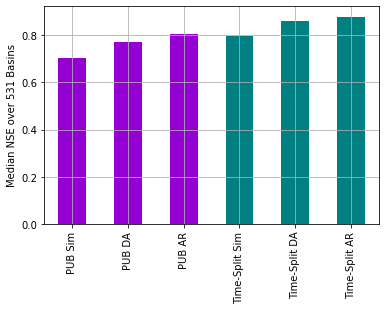

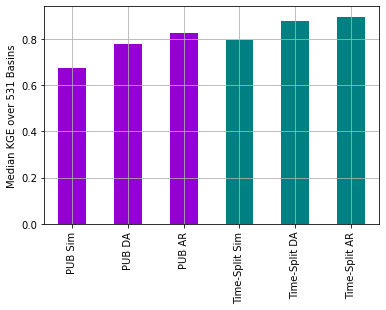

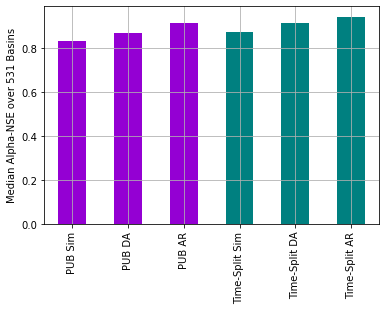

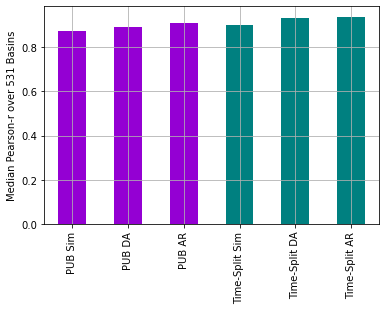

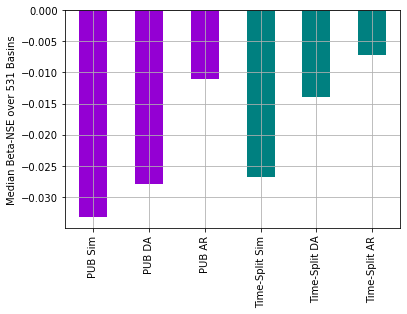

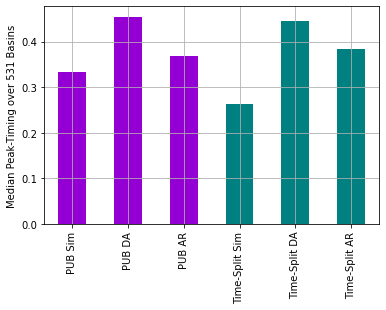

In [29]:
comparison_index = ['PUB Sim', 'PUB DA', 'PUB AR', 'Time-Split Sim', 'Time-Split DA', 'Time-Split AR']

for metric in metrics_list:

    fig = plt.figure()
    
    plotdata = pd.DataFrame(index=basins, columns=comparison_index)
    plotdata['PUB Sim'] = pub_sim[metric]
    plotdata['PUB DA'] = pub_da[metric]
    plotdata['PUB AR'] = pub_ar[metric]
    plotdata['Time-Split Sim'] = time_sim[metric]
    plotdata['Time-Split DA'] = time_da[metric][(0.00, 1, 0)]
    plotdata['Time-Split AR'] = time_ar[metric][(0.00, 0.00, 1, 0)]
    plotdata.median()

    color_mapping = [_model_to_color(model) for model in comparison_index]
    plotdata.median().plot.bar(color=color_mapping)
    # plt.errorbar(plotdata.columns, plotdata.median(), yerr=plotdata.std(), fmt='.', c='k', label='1 \sigma')
    # plt.vlines(plotdata.columns, plotdata.quantile(0.10), plotdata.quantile(0.90), color='grey', lw=5)
    plt.grid()
    # plt.ylim([0,1])
    plt.ylabel(f'Median {metric} over 531 Basins')

    plot_file_name = f"./results/plots/pub_{metric}_comparison.png"
    plt.savefig(plot_file_name)